## PICMUS beamforming with usbmd toolbox
The PICMUS dataset is one of the most widely used ultrasound datasets in the research community. The dataset is available at https://www.creatis.insa-lyon.fr/Challenge/IEEE_IUS_2016/.
In this tutorial we show you how to use the dataset with the usbmd toolbox.

First make sure you have installed the usbmd toolbox using our [installation instructions](../../README.md). Next, we need to prepare the PICMUS dataset for use with the toolbox. After download, convert the dataset to the usbmd format using the following command:
```bash
python usbmd/data/convert/picmus.py --source <path_to_downloaded_dataset> --output <path_to_output_dir>
```

Also make sure to then correctly setup your data paths by running
 ```bash
 python usbmd/datapaths.py
 ```
All paths in the repository are relative to the root of the repository you set using the previous step.

Then add the (relative) location of your converted PICMUS dataset to `./configs/config_picmus_rf.yaml`. In this tutorial, we assume the following relative path:

```yaml
# ./configs/config_picmus_rf.yaml
data:
  dataset_folder: "USBMD_datasets/PICMUS/database/simulation/contrast_speckle/contrast_speckle_simu_dataset_rf"
```


In [1]:
# Change the working directory to the root of the project by moving up in the
# directory tree until the file '.gitignore' is found.
import os

os.environ["KERAS_BACKEND"] = "jax"

while not os.path.exists('.gitignore'):
    os.chdir('..')

# Set to True to run the notebook quickly for testing purposes This is done
# automatically in 'tests/test_run_notebooks.py'
quick_mode = True

In [2]:
# injected parameters
quick_mode = False

In [ ]:
from usbmd import Interface, setup
from usbmd.setup_usbmd import setup
from keras import ops
import matplotlib.pyplot as plt
from usbmd.ops import Pipeline, Downsample, Demodulate, Normalize, EnvelopeDetect, LogCompress, DelayAndSum, TOFCorrection, PatchedGrid, PfieldWeighting

### PICMUS

### Experiments - resolution distortion

#### RF beamforming
Let's load the RF data and beamform it. First have a look at the most easy way to do it using our `Interface` class and setup config functions.

In [4]:
# Loads config, sets data paths and initializes gpu if available
config = setup(config_path="./configs/config_picmus_rf.yaml")

# Override config settings
config.plot.save = False
config.plot.headless = True

# data paths
config.data.dataset_folder = "USBMD_datasets/PICMUS/database/simulation/contrast_speckle/contrast_speckle_simu_dataset_rf"
config.data.file_path = "contrast_speckle_simu_dataset_rf.hdf5"
config.plot.headless = False # you can set to False to see the plots

usbmd: Using config file: ./configs/config_picmus_rf.yaml
usbmd: Git branch and commit: feature/opsv2_migration=e35bf26050236e7f68bfbc6bec815a521140f833
-------------------GPU settings-------------------
     memory
GPU        
0     11011
1     11011
2      2588
3     11011
4     11011
5     11011
6     11011
7     11011
Selecting 1 GPU based on available memory.
Selected GPU 0 with Free Memory: 11011.00 MiB
Hiding GPUs [1, 2, 3, 4, 5, 6, 7] from the system.
--------------------------------------------------


usbmd: Dataset was validated on January 18, 2024
usbmd: Remove /mnt/z/Ultrasound-BMd/data/USBMD_datasets/PICMUS/database/simulation/contrast_speckle/contrast_speckle_simu_dataset_rf/validated.flag if you want to redo validation.


2025-04-25 15:17:34.585069: I external/xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902


usbmd: Running compute_pfield and caching the result to /home/devcontainer15/.usbmd_cache/compute_pfield_634ef561adad7868c4f709199660a575.pkl.
usbmd: Computing pressure field for all transmits
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 100ms/transmits
usbmd: Selected /mnt/z/Ultrasound-BMd/data/USBMD_datasets/PICMUS/database/simulation/contrast_speckle/contrast_speckle_simu_dataset_rf/contrast_speckle_simu_dataset_rf.hdf5


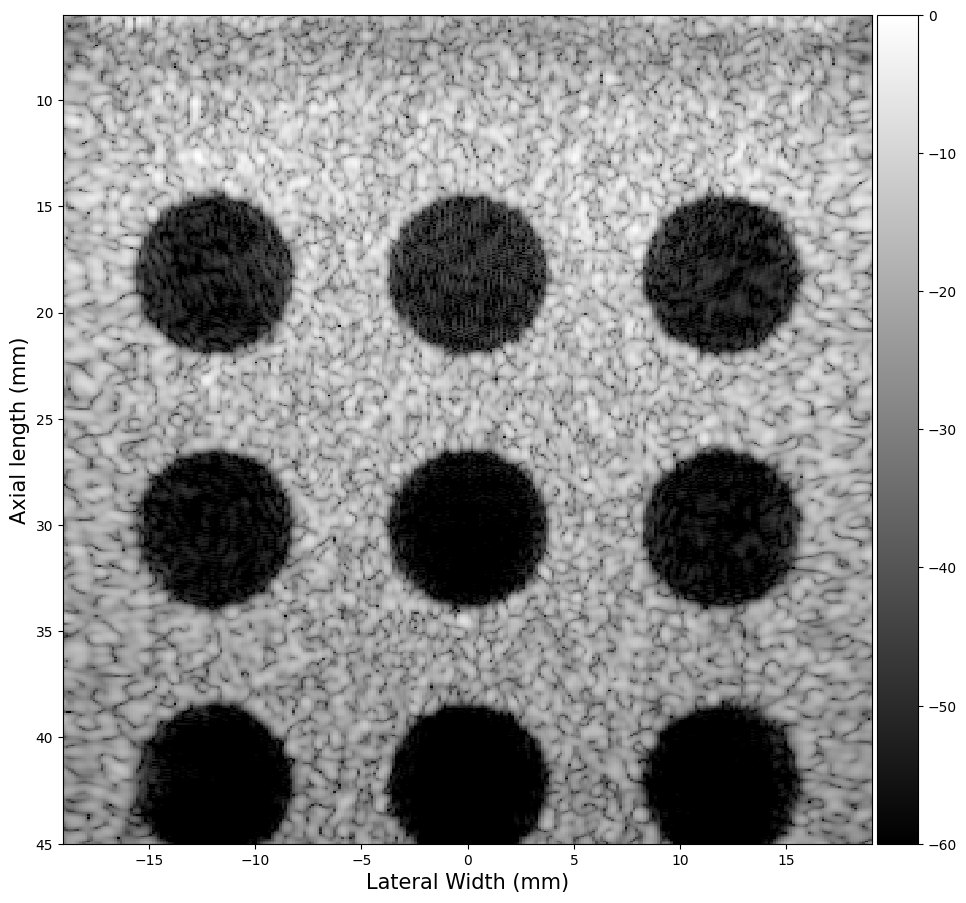

In [5]:
if not quick_mode:
    interface = Interface(config)
    image = interface.run(plot=True)

#### IQ beamforming
We can also load the IQ data and beamform it.

No need to reload a new config (although you can use `./configs/config_picmus_iq.yaml`).
We can simply set n_ch to 2 and change the data file path

In [6]:
config.scan.n_ch = 2
config.data.dataset_folder = "USBMD_datasets/PICMUS/database/simulation/contrast_speckle/contrast_speckle_simu_dataset_iq"
config.data.file_path = "contrast_speckle_simu_dataset_iq.hdf5"

usbmd: Dataset was validated on January 18, 2024
usbmd: Remove /mnt/z/Ultrasound-BMd/data/USBMD_datasets/PICMUS/database/simulation/contrast_speckle/contrast_speckle_simu_dataset_rf/validated.flag if you want to redo validation.
usbmd: Loading cached result for compute_pfield.
usbmd: Selected /mnt/z/Ultrasound-BMd/data/USBMD_datasets/PICMUS/database/simulation/contrast_speckle/contrast_speckle_simu_dataset_rf/contrast_speckle_simu_dataset_rf.hdf5


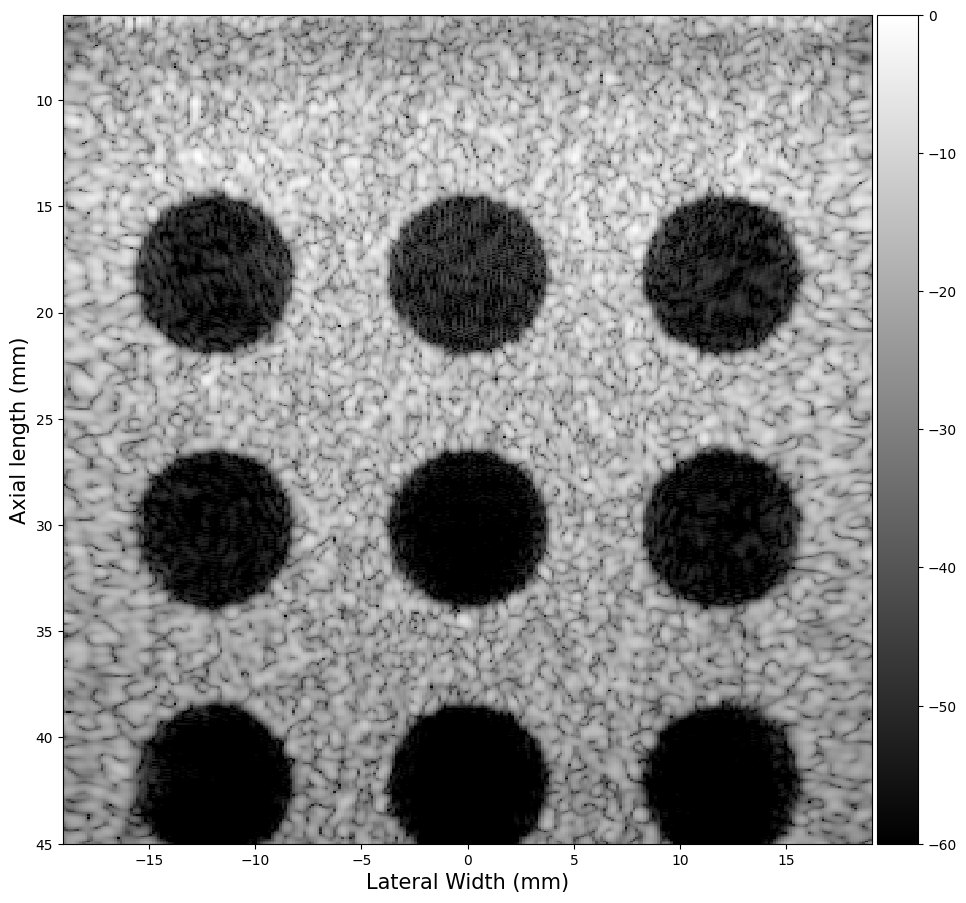

In [13]:
if not quick_mode:
    interface = Interface(config)
    image = interface.run(plot=True)

#### IQ beamforming, but reading RF data
For this, we need a more manual approach. Let's first load the RF data, but now in `raw_data` format. After that we can manually convert it to IQ data and beamform it. We can now either again use the `Process` class, or we can construct our own custom processing `Pipeline`.

usbmd: Dataset was validated on January 18, 2024
usbmd: Remove /mnt/z/Ultrasound-BMd/data/USBMD_datasets/PICMUS/database/simulation/contrast_speckle/contrast_speckle_simu_dataset_rf/validated.flag if you want to redo validation.


usbmd: Loading cached result for compute_pfield.
usbmd: Selected /mnt/z/Ultrasound-BMd/data/USBMD_datasets/PICMUS/database/simulation/contrast_speckle/contrast_speckle_simu_dataset_rf/contrast_speckle_simu_dataset_rf.hdf5
RF data has shape (75, 1891, 128, 1)
IQ data has shape (75, 1891, 128, 2)
usbmd: Loading cached result for compute_pfield.


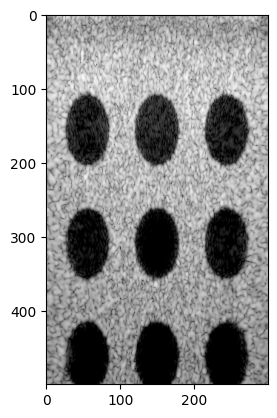

In [ ]:
config.data.dataset_folder = "USBMD_datasets/PICMUS/database/simulation/contrast_speckle/contrast_speckle_simu_dataset_rf"
config.data.file_path = "contrast_speckle_simu_dataset_rf.hdf5"
config.scan.n_ch = 1
config.scan.downsample = 4

if not quick_mode:
    interface = Interface(config)
    # >> load data
    raw_data_rf = interface.get_data()
    # select transmits to use
    raw_data_rf = raw_data_rf[interface.scan.selected_transmits]

    # >> convert RF to IQ
    print(f"RF data has shape {raw_data_rf.shape}")

    # >> process data
    # Let's make a pipeline to process the data
    demodulate_func = Demodulate()

    raw_data_iq = demodulate_func(
        data=raw_data_rf,
        sampling_frequency=interface.scan.sampling_frequency,
        center_frequency=interface.scan.center_frequency,
    )["data"]

    print(f"IQ data has shape {raw_data_iq.shape}")

    # now we have IQ data, the number of channels is 2
    interface.scan.n_ch = 2
    # >> beamform data
    pipeline = Pipeline([
        Downsample(),  # envelope_data -> envelope_data
        PatchedGrid( # for memory efficiency
            [
                TOFCorrection(), # raw_data -> aligned_data
                PfieldWeighting(),
                DelayAndSum(), # aligned_data -> beamformed_data
            ],
            num_patches=100,
        ),
        EnvelopeDetect(),  # beamformed_data -> envelope_data
        Normalize(),  # envelope_data -> envelope_data
        LogCompress(),  # envelope_data -> image
    ],
        with_batch_dim=False,
    )
    params = pipeline.prepare_parameters(probe=interface.probe, scan=interface.scan, config=config)

    image = pipeline(data=raw_data_iq, **params)["data"]
    image = ops.convert_to_numpy(image)

    # TODO: use interface for plotting
    plt.figure()
    plt.imshow(image, cmap="gray")

### Simulations - resolution distortion
For fun, let's look at another PICMUS dataset as an example. This is a simulated dataset, generating a bunch of scatterers. Often we can use it to look at the resolution of our ultrasound pipeline.

#### RF beamforming

In [22]:
# data paths
config.data.dataset_folder = "USBMD_datasets/PICMUS/database/simulation/resolution_distorsion/resolution_distorsion_simu_dataset_rf"
config.data.file_path = "resolution_distorsion_simu_dataset_rf.hdf5"
config.scan.n_ch = 1

if not quick_mode:
    interface = Interface(config)
    image = interface.run()

usbmd: Dataset was validated on January 18, 2024
usbmd: Remove /mnt/z/Ultrasound-BMd/data/USBMD_datasets/PICMUS/database/simulation/resolution_distorsion/resolution_distorsion_simu_dataset_rf/validated.flag if you want to redo validation.
usbmd: Running compute_pfield and caching the result to /home/devcontainer15/.usbmd_cache/compute_pfield_e7645e1544c061c9dffc310385e5005f.pkl.
usbmd: Computing pressure field for all transmits
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/transmits
usbmd: Selected /mnt/z/Ultrasound-BMd/data/USBMD_datasets/PICMUS/database/simulation/resolution_distorsion/resolution_distorsion_simu_dataset_rf/resolution_distorsion_simu_dataset_rf.hdf5


The quality is not really impressive. But wait, in the config we specified the number of transmits (in this case number of plane wave angels) to be 7. The total in the dataset is 75. Let's see how it looks using all of them. 
This can take a bit longer...

usbmd: Dataset was validated on January 18, 2024
usbmd: Remove /mnt/z/Ultrasound-BMd/data/USBMD_datasets/PICMUS/database/simulation/resolution_distorsion/resolution_distorsion_simu_dataset_rf/validated.flag if you want to redo validation.
usbmd: Running compute_pfield and caching the result to /home/devcontainer15/.usbmd_cache/compute_pfield_09886d08ed42a8b0f764cc2639517432.pkl.
usbmd: Computing pressure field for all transmits
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/transmits
usbmd: Selected /mnt/z/Ultrasound-BMd/data/USBMD_datasets/PICMUS/database/simulation/resolution_distorsion/resolution_distorsion_simu_dataset_rf/resolution_distorsion_simu_dataset_rf.hdf5


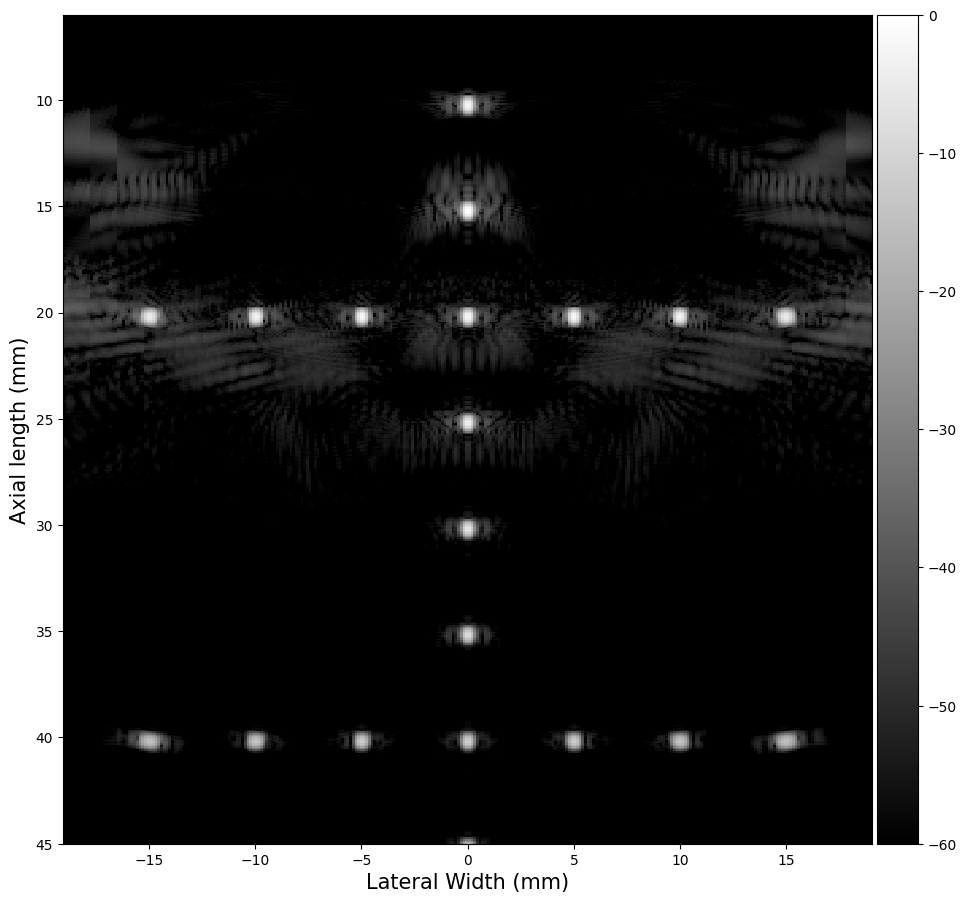

In [23]:
if not quick_mode:
    config.scan.selected_transmits = 30

    operations = [
        {"name": "demodulate"},
        {"name": "downsample",
         "params": {"factor": 4}},
        {"name": "patched_grid",
         "params": {
             "operations": [
                 {"name": "tof_correction",
                  "params": {"apply_phase_rotation": True}},
                 {"name": "pfield_weighting"},
                 {"name": "delay_and_sum"}
             ],
             "num_patches": 100
         }},
        {"name": "envelope_detect"},
        {"name": "normalize"},
        {"name": "log_compress"}
    ]

    config.pipeline.operations = operations

    interface = Interface(config)
    image = interface.run(plot=True)